# MDTF Example Diagnostic POD for Multiple Cases / Experiments
### Uses: Data catalogs
### Disclaimer: Debug mode with some hardcoded values will be found in this notebook. MDTF integration is underway. This is essentially to see how things may flow from the user configuration files to the MDTF framework and into the POD, including figure generation. 

In [3]:
# ================================================================================
#
# This file is part of the Multicase Example Diagnostic POD of the MDTF code
# package (see mdtf/MDTF-diagnostics/LICENSE.txt)
#
# Example Diagnostic POD
#
#   Last update: March 2024 (exploring intake-esm catalog in the MDTF framework and the POD)
#
#   This example builds upon the single case `example` POD
#   and illustrates how to design and implement a POD that uses multiple
#   model source datasets. These can be the same experiment with different
#   models, two different experiments from the same model, or two different
#   time periods within the same simulation.
#
#   Version & Contact info
#
#   - Version/revision information: version 1.1 (Oct-2022)
#   - Model Development Task Force Framework Team
#
#   Open source copyright agreement
#
#   The MDTF framework is distributed under the LGPLv3 license (see LICENSE.txt).
#
#   Functionality
#
#   Metadata associated with the different cases are passed from the
#   framework to the POD via a yaml file (case_info.yaml) that the POD reads into a dictionary.
#   The POD iterates over the case entries in the dictionary and opens the input datasets.
#   The `tas` variable is extracted for each case and the time average is taken over the dataset.
#   Anomalies are calculated relative to the global mean and then zonally-averaged. The resulting plot
#   contains one line for each case.
#
#   Required programming language and libraries
#
#     * Python >= 3.10
#     * xarray
#     * matplotlib
#     * intake
#     * yaml
#     * sys
#     * os
#     * numpy
#
#   Required model output variables
#
#     * tas - Surface (2-m) air temperature (CF: air_temperature)
#
#   References
#
#      Maloney, E. D, and Co-authors, 2019: Process-oriented evaluation of climate
#         and wether forcasting models. BAMS, 100(9), 1665-1686,
#         doi:10.1175/BAMS-D-18-0042.1.

## Import necessary packages

In [1]:
# Import modules used in the POD
import os
import matplotlib

matplotlib.use("Agg")  # non-X windows backend

import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import intake
import sys
import yaml
import warnings

warnings.filterwarnings("ignore")

NOTE: We are exploring..so..there will be some hardcoded paths here, which MDTF framework
will help us remove when the feature is available in the framework.

## Part 1: Read in case info (in the format (YAML) that MDTF generates for the run)

In [8]:
# Debugging: remove following line in final PR
os.environ["WORK_DIR"] = "/nbhome/a1r/wkdir/example_multicase"
os.environ["case_env_file"] = "/home/a1r/github/aparna/MDTF-diagnostics/diagnostics/example_multicase/case_info.yaml"
os.environ['CATALOG_FILE'] = "/home/a1r/github/aparna/MDTF-diagnostics/diagnostics/example_multicase/amip_c96L65_am5f3b1r0_pdclim1850F_combined.json" 


In [9]:
# Receive a dictionary of case information from the framework
case_env_file = os.environ["case_env_file"]
assert(os.path.isfile(case_env_file)), f"case environment file {case_env_file} not found"
with open(case_env_file, 'r') as stream:
    try:
        case_info = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [10]:
cat_def_file = case_info['CATALOG_FILE']
case_list = case_info['CASE_LIST']
# all cases share variable names and dimension coords, so just get first result for each
tas_var = [case['tas_var'] for case in case_list.values()][0]
time_coord = [case['time_coord'] for case in case_list.values()][0]
lat_coord = [case['lat_coord'] for case in case_list.values()][0]
lon_coord = [case['lon_coord'] for case in case_list.values()][0]
# open the csv file using information provided by the catalog definition file


## What is in the data catalog? 

In [12]:
cat = intake.open_esm_datastore(cat_def_file)
cat

,unique
activity_id,1
institution_id,0
source_id,0
experiment_id,2
frequency,3
modeling_realm,1
table_id,0
member_id,0
grid_label,0
variable_id,64


In [13]:
cat.df

,activity_id,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,chunk_freq,grid_label.1,platform,dimensions,cell_methods,path
0,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,3hr,atmos_cmip,NaN,NaN,NaN,pr,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
1,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,3hr,atmos_cmip,NaN,NaN,NaN,rlut,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
2,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,3hr,atmos_cmip,NaN,NaN,NaN,pr,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
3,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,3hr,atmos_cmip,NaN,NaN,NaN,rlut,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
4,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,3hr,atmos_cmip,NaN,NaN,NaN,pr,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,dev,NaN,NaN,c384L65_am5f3b1r0_amip,daily,atmos_cmip,NaN,NaN,NaN,zg500,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c384L65_am5f3b1r0_a...
781,dev,NaN,NaN,c384L65_am5f3b1r0_amip,daily,atmos_cmip,NaN,NaN,NaN,hurs,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c384L65_am5f3b1r0_a...
782,dev,NaN,NaN,c384L65_am5f3b1r0_amip,daily,atmos_cmip,NaN,NaN,NaN,huss,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c384L65_am5f3b1r0_a...
783,dev,NaN,NaN,c384L65_am5f3b1r0_amip,daily,atmos_cmip,NaN,NaN,NaN,pr,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c384L65_am5f3b1r0_a...


## Searching for TAS DAILY output for my POD

In [14]:
# filter catalog by desired variable and output frequency
tas_subset = cat.search(variable_id=tas_var, frequency="daily")
tas_subset 

,unique
activity_id,1
institution_id,0
source_id,0
experiment_id,2
frequency,1
modeling_realm,1
table_id,0
member_id,0
grid_label,0
variable_id,1


In [16]:
tas_subset.df

,activity_id,institution_id,source_id,experiment_id,frequency,modeling_realm,table_id,member_id,grid_label,variable_id,temporal_subset,chunk_freq,grid_label.1,platform,dimensions,cell_methods,path
0,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
1,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
2,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
3,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
4,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
5,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
6,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
7,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
8,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...
9,dev,NaN,NaN,c96L65_am5f3b1r0_pdclim1850F,daily,atmos_cmip,NaN,NaN,NaN,tas,NaN,NaN,NaN,NaN,NaN,NaN,/archive/am5/am5/am5f3b1r0/c96L65_am5f3b1r0_pd...


In [17]:
# convert tas_subset catalog to an xarray dataset dict
tas_dict = tas_subset.to_dataset_dict(
    xarray_open_kwargs={"decode_times": True, "use_cftime": True}
)
# get key list for new dictionary. Each key corresponds to a case
#tas_keys = [key for key in tas_dict.keys()]




--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.frequency.modeling_realm.variable_id'


## Let us do some calculations

In [18]:
# Part 2: Do some calculations (time and zonal means)
# ---------------------------------------------------

tas_arrays = {}

# Loop over cases
for k, v in tas_dict.items():
    # load the tas data for case k
    print("case:",k)
    arr = tas_dict[k][tas_var]

    # take the time mean
    arr = arr.mean(dim=tas_dict[k][time_coord].name)

    # this block shuffles the data to make this single case look more
    # interesting.  ** DELETE THIS ** once we test with real data

    arr.load()
    values = arr.to_masked_array().flatten()
    np.random.shuffle(values)
    values = values.reshape(arr.shape)
    arr.values = values

    # convert to anomalies
    arr = arr - arr.mean()

    # take the zonal mean
    arr = arr.mean(dim=tas_dict[k][lon_coord].name)

    tas_arrays[k] = arr



case: c96L65_am5f3b1r0_pdclim1850F.daily.atmos_cmip.tas
case: c384L65_am5f3b1r0_amip.daily.atmos_cmip.tas


### We are comparing the above cases


## Let us PLOT

Let's plot!
--------------------------------------


Text(0.5, 1.0, 'Zonal Mean Surface Air Temperature Anomaly')

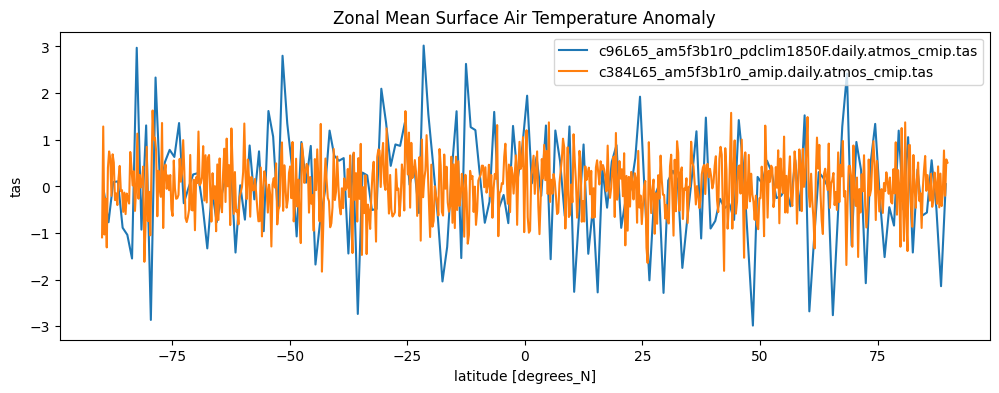

In [20]:

# Part 3: Make a plot that contains results from each case
# --------------------------------------------------------
print("Let's plot!")
print("--------------------------------------")

# set up the figure
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(1, 1, 1)

# loop over cases
for k, v in tas_arrays.items():
    v.plot(ax=ax, label=k)

# add legend
plt.legend()

# add title
plt.title("Zonal Mean Surface Air Temperature Anomaly")


In [21]:
plt.show()

## Save the plots in work directory 

In [22]:

# save the plot in the right location
work_dir = os.environ["WORK_DIR"]
assert os.path.isdir(f"{work_dir}/model/PS"), f'Assertion error: {work_dir}/model/PS not found'

plt.savefig(f"{work_dir}/model/PS/example_model_plot.eps", bbox_inches="tight")

# Part 4: Close the catalog files and
# release variable dict reference for garbage collection
# ------------------------------------------------------
cat.close()
tas_dict = None


# Part 5: Confirm POD executed successfully
# ----------------------------------------
print("Last log message by example_multicase POD: finished successfully!")
sys.exit(0)


Last log message by example_multicase POD: finished successfully!


<Figure size 640x480 with 0 Axes>